## 캐글 타이타닉 : https://www.kaggle.com/competitions/titanic/overview
### 목표 : 전처리 방법 변경 및 모델을 Tensorflow 딥러닝 모델로 변경하여 제출 후 스코어 0.8 이상 도달하기

### baseline

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
X = pd.read_csv('train.csv')
y = pd.read_csv('test.csv')

In [13]:
def bar(data, feature):
    survived = data[data['Survived']==1][feature].value_counts()
    dead = data[data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

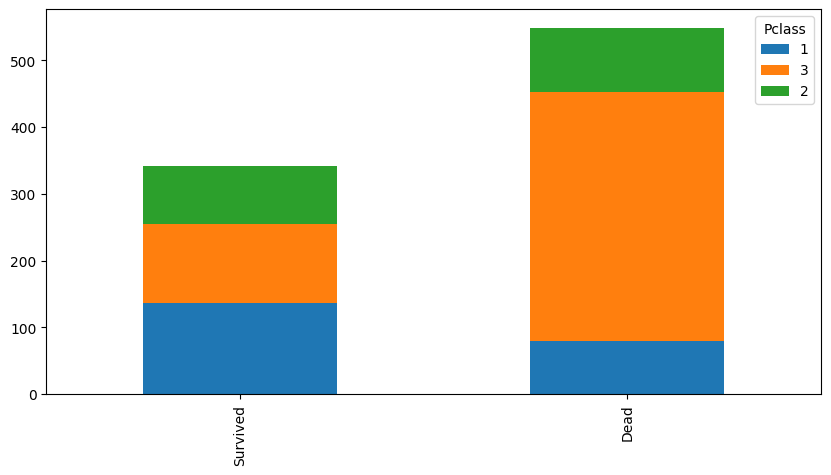

In [17]:
bar(X, 'Pclass')

In [19]:
X.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
train_test_data = [X, y] # combining train and test dataset

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [22]:
X['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

In [24]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

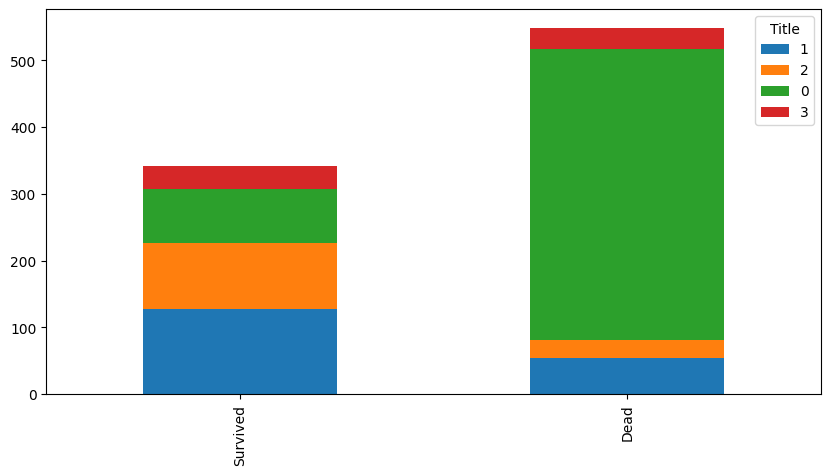

In [25]:
bar(X, 'Title')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 기본 파라미터
param_grid = {
    'learning_rate': [0.01, 0.001],
    'batch_size': [32, 64],
    'num_epochs': [50, 100],
    'scaling': ['standard', 'minmax']
}

# 모델 정의
class TitanicNet(nn.Module):
    def __init__(self, input_size):
        super(TitanicNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# 최적의 val_accuracy와 모델 저장용 디렉토리
best_val_accuracy = 0
best_model_path = None

# Grid Search
for params in ParameterGrid(param_grid):
    # 데이터 정규화 또는 표준화
    if params['scaling'] == 'standard':
        scaler = StandardScaler()
    elif params['scaling'] == 'minmax':
        scaler = MinMaxScaler()
        
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    # 모델 초기화
    model = TitanicNet(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # Early Stopping 설정
    patience = 10
    best_epoch_val_accuracy = 0
    epochs_no_improve = 0

    # 학습
    for epoch in range(params['num_epochs']):
        # 미니배치 학습
        model.train()
        permutation = torch.randperm(X_train_tensor.size()[0])
        for i in range(0, X_train_tensor.size()[0], params['batch_size']):
            indices = permutation[i:i + params['batch_size']]
            batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        # 검증 데이터 평가
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor).item()
            val_predicted = (val_outputs > 0.5).float()
            val_accuracy = accuracy_score(y_val_tensor, val_predicted)
        
        # 얼리스토핑 체크
        if val_accuracy > best_epoch_val_accuracy:
            best_epoch_val_accuracy = val_accuracy
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # 최적의 모델 저장
    if best_epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = best_epoch_val_accuracy
        best_model_path = f"model_lr{params['learning_rate']}_bs{params['batch_size']}_epochs{params['num_epochs']}_scaling{params['scaling']}.pt"
        torch.save(model.state_dict(), best_model_path)

    print(f"Finished training with params: {params}")
    print(f"Val Accuracy: {best_epoch_val_accuracy:.4f}")

print(f"Best model saved at: {best_model_path} with val_accuracy: {best_val_accuracy:.4f}")


NameError: name 'X_train' is not defined